# Generative Adversarial Networks

## Summary

- Introduction
- GAN flavours
- Deep Convolutional GANs
- StyleGANs

## Introduction

### GAN in a nutshell

- Simultaneously train two models:
  - One tries to generate realistic data.
  - The other tries to discriminate between real and generated data.
- Each model is trained to best the other.
- First described in [Generative Adversarial Nets
](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) by Goodfellow et al. (2014).
- [NIPS 2016 Tutorial](https://arxiv.org/abs/1701.00160)


[![GAN overview](images/gan1.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

[![GAN process](images/gan2.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

### Training process

- The generator creates images from random noise.
- Generated images are mixed with real ones.
- The discriminator is trained on these mixed images.
- The generator's parameters are updated in a direction that makes the discriminator more likely to classify generated data as "real".

### Example: generating fashion images with a basic GAN

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [3]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [4]:
# Load the Fashion-MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Change pixel values from (0, 255) to (0, 1)
x_train = train_images.astype("float32") / 255
x_test = test_images.astype("float32") / 255

# Set apart the first 5,000 reviews as validation data
x_val, x_train = x_train[:5000], x_train[5000:]
y_val, y_train = train_labels[:50000], train_labels[50000:]
y_test = test_labels

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}. y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}. y_test: {y_test.shape}")

x_train: (55000, 28, 28). y_train: (10000,)
x_val: (5000, 28, 28). y_val: (50000,)
x_test: (10000, 28, 28). y_test: (10000,)


In [5]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [6]:
codings_size = 30

generator = Sequential([
    Dense(100, activation="selu", input_shape=(codings_size,)),
    Dense(150, activation="selu"),
    Dense(28 * 28, activation="sigmoid"),
    Reshape((28, 28))
])
discriminator = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(150, activation="selu"),
    Dense(100, activation="selu"),
    Dense(1, activation="sigmoid")
])
gan = Sequential([generator, discriminator])

In [7]:
# Print model summary
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            136634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________


In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [10]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch [{epoch+1}/{n_epochs}]...")
        for x_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
    print("Training complete!")

In [11]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

Epoch [1/5]...
Epoch [2/5]...
Epoch [3/5]...
Epoch [4/5]...
Epoch [5/5]...
Training complete!


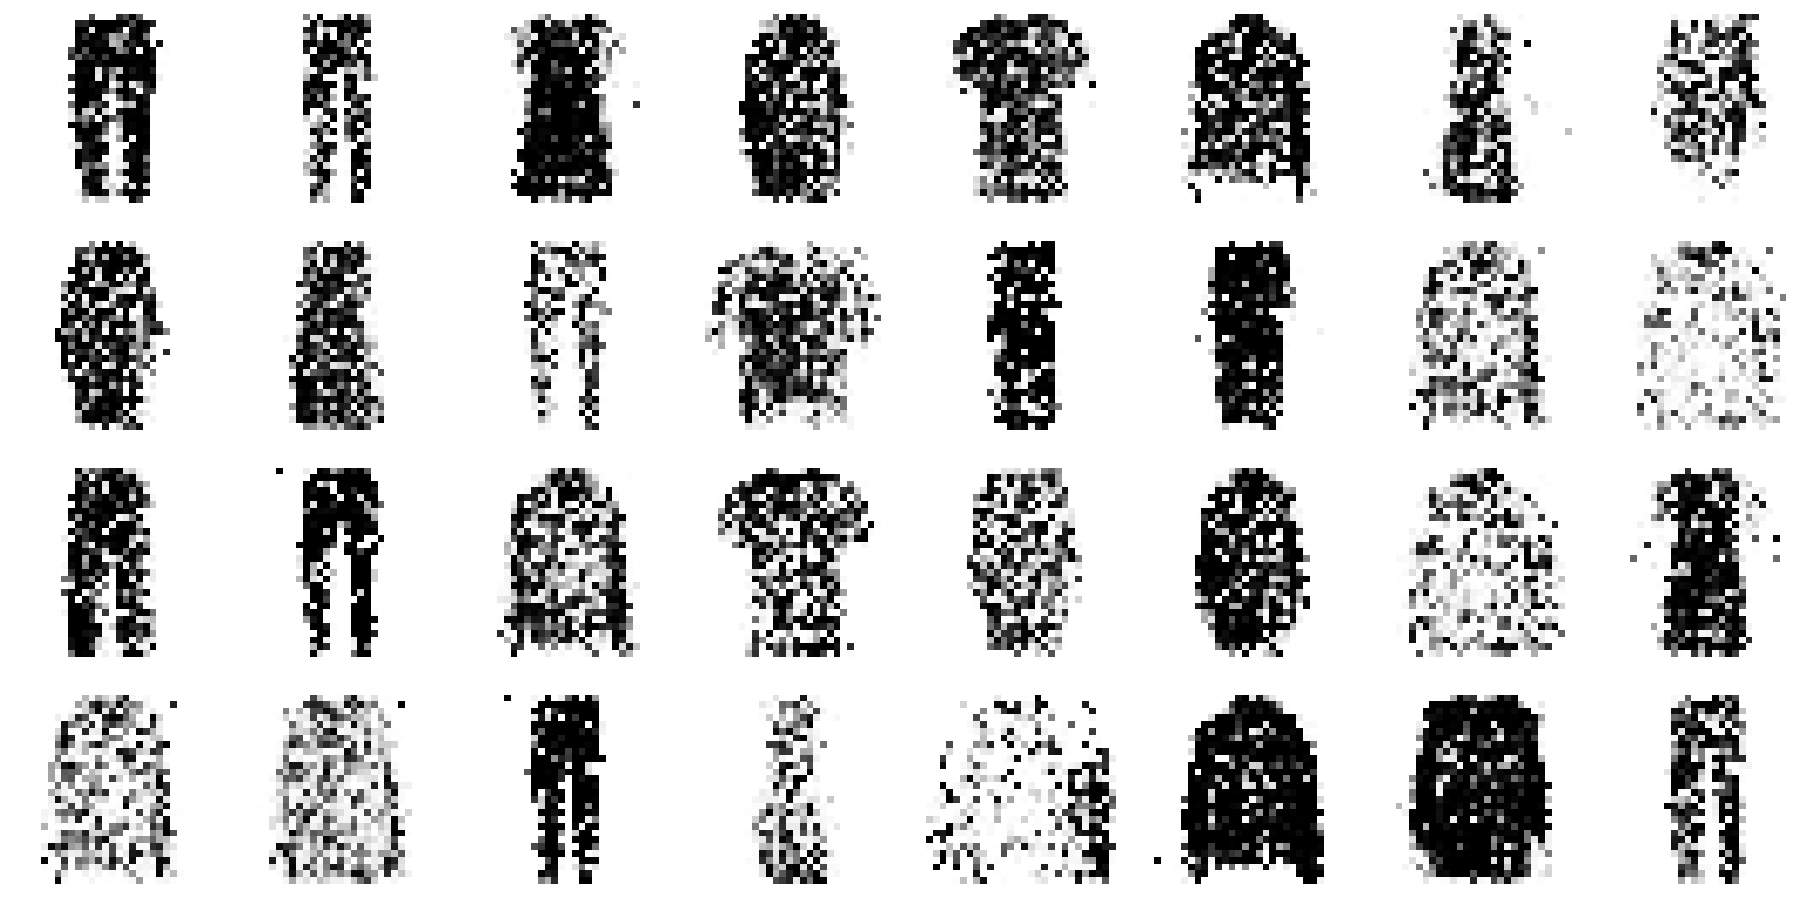

In [12]:
noise = tf.random.normal(shape=(batch_size, codings_size))
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

### Specificities and gotchas

- A GAN is a *dynamic system* that evolves at each training step.
- Interestingly, the generator never sees images froms the training set directly: all its informations come from the discriminator.
- Training can be tricky: noisy generated data, vanishing gradients, domination of one side...
- GAN convergence theory is an active area of research.
- [GAN Open Questions](https://distill.pub/2019/gan-open-problems/)

## GAN flavours

### The GAN landscape

[![GAN flavours](images/gan_flavours.png)](https://blog.floydhub.com/gans-story-so-far/)

### GAN progress on face generation

[![GAN progress from 2014 to 2018](images/gan_2014_2018.jpg)](https://twitter.com/goodfellow_ian/status/1084973596236144640)

### GAN use cases: not just images!

- Writing a novel "in the style of an author".
- [Generating music](https://arxiv.org/abs/1805.07848) ([samples](https://www.youtube.com/watch?v=vdxCqNWTpUs)).
- Generating realistic passwords for hackers.
- Generating videos ([example](https://www.youtube.com/watch?time_continue=3&v=ab64TWzWn40&feature=emb_logo)).
- [Generating video game levels](https://arxiv.org/abs/1910.01603).
- ...

## Deep Convolutional GANs

### Architecture

### Example: generate handwritten digits with a DCGAN

This example trains a Deep Convolutional GAN on the MNIST dataset. Check it out on the [TensorFlow website](https://www.tensorflow.org/tutorials/generative/dcgan).

## StyleGANs